In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy

In [17]:
#!pip install git+https://github.com/google-research/tensorflow_constrained_optimization
import tensorflow_constrained_optimization as tfco

To fully understand everything you may want to learn about Gaussian process first. Here the focus is on how to implement its optimization, so only a brief description is provided; feel free to check the literature.. 


Gaussian process defines a prior probability over functions. Given an arbitrary set of points $x_1,...,x_N$, the assumption is that the function values $y(x_1),...,y(x_N)$ jointly have a Gaussian distribution. The goal is to fit the parameters of this join distribution. The main trick is that the mean and covariance are defined as functions of $x$:
$$ y(x) \sim GP(m(x),k(x,x'))$$

$k(x,x')$ is a kernel function which estimates the covariance and can be defined in different ways. The one we used in this example is:

$$k(x,x') = \theta_1 exp(-\frac{||x-x'||^2}{2\theta_2})$$

And the optimization is to find out proper parameters $\theta_1$ and $\theta_2$; both of the parameters are positive, so we have two constraints.




### Dataset generation

Text(0, 0.5, '$f(x)$')

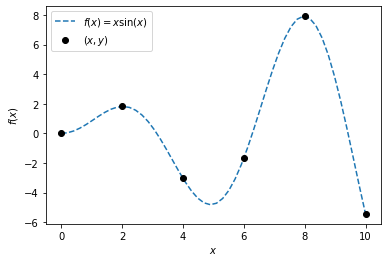

In [5]:
# Lets assume the generative process is the follwoing:
y_process = lambda x: x * np.sin(x)
x_full_range = np.linspace(start=0, stop=10, num=50).reshape(-1, 1)
# and the samples drwan from this process are:
X = np.linspace(start=0, stop=10, num=6).reshape(-1, 1)
y = np.squeeze(y_process(X)).reshape(-1, 1)

#plt.plot(np.arange(0,10,0.1))
plt.plot(x_full_range, y_process(x_full_range), linestyle='--', label=r"$f(x) =x\sin(x)$",)
plt.plot(X, y, 'ko', label=r"$(x,y)$")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")


### Loss function

The loss function is negative log likelihood, so we would like to find the parameters which fit a multivariate Gaussian distribution best:
$$ -ln P(y|X,\theta_1, \theta_2) = -\frac{1}{2}(y-\mu_y)^T \Sigma_{\theta}^{-1}(y-\mu_y) + \frac{1}{2}ln|\Sigma_\theta|$$

The loss function only shows the terms which are dependent on the trainable parameters. The code is:

In [6]:
def objective():
    mean_y = lambda : np.mean(y_tr)
    y_tr_norm = y_tr - mean_y()
    Covariance = Kernel(X_tr,X_tr)
    Kernel_inv = tf.linalg.inv(Covariance)
    data_fit  = 0.5*tf.tensordot(tf.matmul(y_tr_norm, Kernel_inv, transpose_a=True), y_tr_norm, axes=1)
    complexity_penalty = 0.5*tf.math.log(tf.linalg.det(Covariance))
    return complexity_penalty + data_fit[0]

Let's make the Kernel function:

In [7]:
def Kernel(x1,x2):
    kernel = theta1 * tf.math.exp(-tf.math.squared_difference(x1,tf.transpose(x2))/2*theta2)
    return kernel

### Model fitting

In [8]:
# setting the data in TF constant form
X_tr = tf.constant(X,dtype=tf.float32)
y_tr = tf.constant(y, dtype=tf.float32)


we can make the class now

In [9]:
class FitGP(tfco.ConstrainedMinimizationProblem):
    def __init__(self, theta1, theta2):
        self.theta1 = theta1
        self.theta2 = theta2
        
    def Kernel(self,x1,x2):
        kernel = self.theta1 * tf.math.exp(-tf.math.squared_difference(x1,tf.transpose(x2))/2*self.theta2)
        return kernel
        
    def objective(self):
        mean_y = lambda : np.mean(y_tr)
        y_tr_norm = y_tr - mean_y()
        Covariance = self.Kernel(X_tr,X_tr)
        Kernel_inv = tf.linalg.inv(Covariance)
        data_fit  = 0.5*tf.tensordot(tf.matmul(y_tr_norm, Kernel_inv, transpose_a=True), y_tr_norm, axes=1)
        complexity_penalty = 0.5*tf.math.log(tf.linalg.det(Covariance))
        return complexity_penalty + data_fit[0]
    @property
    def num_constraints(self):
        return 2
    
    def constraints(self):
        constraint1 = -self.theta1
        constraint2 = -self.theta2
        return tf.stack([constraint1, constraint2])
    

In [10]:
# Initializing the parameters
theta1= tf.Variable([1], dtype=tf.float32)
theta2=tf.Variable([0.1],dtype=tf.float32)
## Instantiating the problem
problem = FitGP(theta1, theta2)

In [11]:
optim = tf.optimizers.Adagrad(1.)
optimizer = tfco.LagrangianOptimizer(optim,
                                    num_constraints=problem.num_constraints)
var_list = list(problem.trainable_variables) + optimizer.trainable_variables()

In [12]:
for ii in range(1000):
    optimizer.minimize(problem, var_list)
    if ii % 100 == 0:
        print(f'iteration {ii}, the objective is {problem.objective()}', end="")
        print(f' theta1 ={problem.theta1.numpy()}, and theta2={problem.theta2.numpy()}')

iteration 0, the objective is [32.585915] theta1 =[2.], and theta2=[1.1]
iteration 100, the objective is [27.130411] theta1 =[2.4936662], and theta2=[1.110772]
iteration 200, the objective is [24.518642] theta1 =[2.8359475], and theta2=[1.1196165]
iteration 300, the objective is [22.89056] theta1 =[3.1058466], and theta2=[1.1273657]
iteration 400, the objective is [21.744589] theta1 =[3.3319008], and theta2=[1.1343697]
iteration 500, the objective is [20.87872] theta1 =[3.5280619], and theta2=[1.1408195]
iteration 600, the objective is [20.193222] theta1 =[3.702318], and theta2=[1.1468331]
iteration 700, the objective is [19.632235] theta1 =[3.8597174], and theta2=[1.1524903]
iteration 800, the objective is [19.161636] theta1 =[4.003676], and theta2=[1.1578485]
iteration 900, the objective is [18.75919] theta1 =[4.1366243], and theta2=[1.1629506]


### Prediction

Gaussian process is a regression model and we can predict the mean and standard deviation for any new given point $x_{test}$. The prediction function is provided below. For more information on how it is done, please refer to literature (e.g. https://peterroelants.github.io/posts/gaussian-process-tutorial/)

In [13]:
def predict(X_tr,y_tr, X_ts, mu_tr,mu_tst, kernel_func):
    Sigma11 = kernel_func(X_tr, X_tr)
    Sigma22 = kernel_func(X_tst, X_tst)
    Sigma12 = kernel_func(X_tr, X_tst)
    solved = scipy.linalg.solve(Sigma11, Sigma12, assume_a='pos').T
    mu21 = mu_tst + solved @ (y_tr - mu_tr)
    Sigma2 = Sigma22 - (solved @ Sigma12)
    return mu21.numpy().ravel(), np.diag(Sigma2)

In [14]:
X_tst = np.linspace(start=0, stop=12, num=100).reshape(-1, 1)
X_tst = tf.constant(X_tst, dtype=tf.float32)
mu1 = mu2 = np.mean(y_tr)

In [15]:
mu21, Sigma2 = predict(X_tr,y_tr, X_tst, mu1,mu2, problem.Kernel)

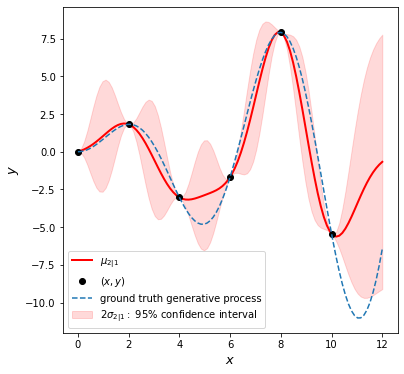

In [16]:
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 6))
ax.fill_between(X_tst.numpy().ravel().flat, mu21-2*Sigma2, mu21+2*Sigma2, color='red', 
                  alpha=0.15, label='$2 \sigma_{2|1}:$ 95% confidence interval')
ax.plot(X_tst, mu21, 'r-', lw=2, label='$\mu_{2|1}$')
ax.plot(X_tr, y_tr, 'ko', linewidth=2, label='$(x, y)$')
ax.plot(X_tst, y_process(X_tst), linestyle='--', label='ground truth generative process')
ax.set_xlabel('$x$', fontsize=13)
ax.set_ylabel('$y$', fontsize=13)
ax.legend()